In [1]:
%pip install pandas yfinance yahoofinancials scikit-learn tensorflow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

df = yf.download('BBCA', 
                      start='2019-01-01', 
                      end='2025-05-01', 
                      progress=False,
)
df.head()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,BBCA,BBCA,BBCA,BBCA,BBCA
Date,,,,,
2019-01-02,35.736706,35.805198,34.966148,34.966148,104400
2019-01-03,35.651093,35.788080,35.325745,35.668216,70800
2019-01-04,36.421642,36.421642,35.976431,35.976431,39000
2019-01-07,36.866848,36.918216,36.387389,36.421637,58450
2019-01-08,37.209324,37.277819,36.883980,37.140832,65950


In [3]:
df = df.reset_index()
df.columns = ['date', 'close', 'high', 'low', 'open', 'volume']
df.head()

,date,close,high,low,open,volume
0,2019-01-02,35.736706,35.805198,34.966148,34.966148,104400
1,2019-01-03,35.651093,35.788080,35.325745,35.668216,70800
2,2019-01-04,36.421642,36.421642,35.976431,35.976431,39000
3,2019-01-07,36.866848,36.918216,36.387389,36.421637,58450
4,2019-01-08,37.209324,37.277819,36.883980,37.140832,65950


In [4]:
import numpy as np

df['date'] = pd.to_datetime(df['date'])
df.sort_index(inplace=True)
df.set_index('date', inplace=True)
df.head()

,close,high,low,open,volume
date,,,,,
2019-01-02,35.736706,35.805198,34.966148,34.966148,104400
2019-01-03,35.651093,35.788080,35.325745,35.668216,70800
2019-01-04,36.421642,36.421642,35.976431,35.976431,39000
2019-01-07,36.866848,36.918216,36.387389,36.421637,58450
2019-01-08,37.209324,37.277819,36.883980,37.140832,65950


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[['close', 'high', 'low', 'open', 'volume']])
df_scaled = pd.DataFrame(scaled_values, columns=['close', 'high', 'low', 'open', 'volume'])
df_scaled['date'] = df.index
df_scaled = df_scaled[['date', 'close', 'high', 'low', 'open', 'volume']]
df_scaled.head()

,date,close,high,low,open,volume
0,2019-01-02,0.184709,0.150764,0.169763,0.151357,0.018876
1,2019-01-03,0.182915,0.150391,0.177349,0.166361,0.010837
2,2019-01-04,0.199057,0.164191,0.191077,0.172948,0.003230
3,2019-01-07,0.208384,0.175007,0.199747,0.182463,0.007883
4,2019-01-08,0.215558,0.182840,0.210223,0.197833,0.009677


In [6]:
import pickle

with open("minmax_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [7]:
# Tambahkan kolom target dan pastikan kolom date jadi datetime
df_scaled['target'] = df['close'].values  # atau gunakan y kalau sudah ada
df_scaled['date'] = pd.to_datetime(df_scaled['date'])

# Tentukan rentang waktu
training_start = pd.to_datetime('2019-01-01')
training_end = pd.to_datetime('2024-01-31')
testing_start = pd.to_datetime('2024-02-01')
testing_end = pd.to_datetime('2025-05-01')

# Split data berdasarkan tanggal
train_data = df_scaled[(df_scaled['date'] >= training_start) & (df_scaled['date'] <= training_end)]
test_data = df_scaled[(df_scaled['date'] >= testing_start) & (df_scaled['date'] <= testing_end)]

# Pisahkan fitur dan target
X_train = train_data.drop(columns=['date', 'target'])
y_train = train_data['target']
X_test = test_data.drop(columns=['date', 'target'])
y_test = test_data['target']

# Cek ukuran
print("Training data:", X_train.shape, y_train.shape)
print("Testing data:", X_test.shape, y_test.shape)

Training data: (1279, 5) (1279,)
Testing data: (312, 5) (312,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

# Bangun model ANN
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Kompilasi
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Training model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping]
)

d:\KSM Android - DS Beginner\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 2317.2031 - val_loss: 2.0847
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.3814 - val_loss: 3.3447
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 33.4224 - val_loss: 5.6432
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 24.2192 - val_loss: 1.9788
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.9157 - val_loss: 3.2612
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 21.0311 - val_loss: 0.4830
Epoch 7/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 20.3137 - val_loss: 0.2995
Epoch 8/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.1107 - val_loss: 1.1901
Epoch 9/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 20.2684 - val_loss: 2.3712
Epoch 10/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.1410 - val_loss: 0.8362
Epoch 11/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.3645 - val_loss: 6.9664
Epoch 12/1000
64/64 ━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
MAE=0.4343738800440079, RMSE=0.4969289334922444, R²=0.9841289132934302


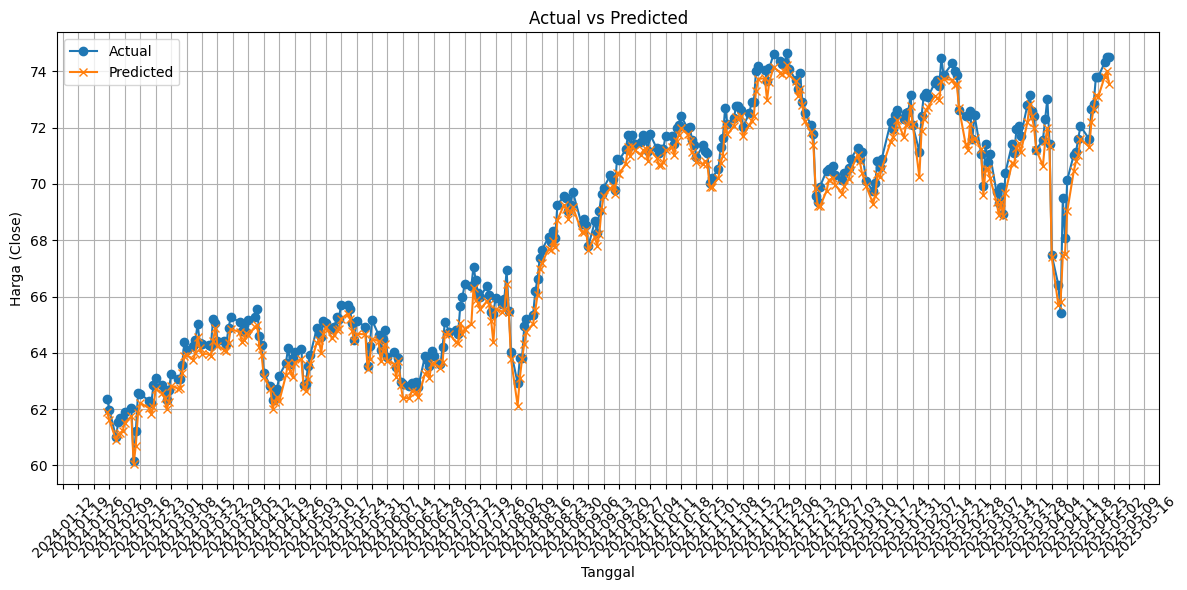

In [9]:
# Prediksi
predictions = model.predict(X_test).flatten()

# Evaluasi
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"MAE={mae}, RMSE={rmse}, R²={r2}")

# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label="Actual", marker='o')
plt.plot(test_data['date'], predictions, label="Predicted", marker='x')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("Actual vs Predicted")
plt.xlabel('Tanggal')
plt.ylabel('Harga (Close)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
model.save("ann_model_bca.h5")

In [11]:
!pip freeze > requirements.txt